# Janusze AI
* Rafał Kobiela
* Mateusz Krubiński
* Piotr Bródka

### Bot odpowiadający na pytania użytkownika

In [1]:
import sys
import numpy as np
import pandas as pd
import gensim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.sequence import pad_sequences

/home/rafal/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
def load_glove_embeddings(file='glove.6B.300d'):
    output_file = config.config['embeddings_path']['glove']
    embeddings_index = {}
    wrong = []
    repeated = []
    if(os.path.isfile(output_file)):
        print('Loading serialized embeddings...')
        embeddings_index = pkl.load(open(output_file, "rb"))
    else:
        print('Loading raw embeddings from file...')
        f = open(file, encoding = 'utf8')
        for line in tqdm(f):
            values = line.split()
            if len(values) == 301:
                word = values[0]
                coefs = np.asarray(values[1:], dtype = 'float32')
                if word not in embeddings_index.keys():
                    embeddings_index[word] = coefs
                else:
                    repeated.append(values)
            else:
                wrong.append(values)
        f.close()
        pkl.dump(embeddings_index, open(output_file, "wb"))
    print('Found %s word vectors. %s wrong, %s repeated' % (len(embeddings_index), len(wrong), len(repeated)))
    return embeddings_index, wrong, repeated

def load_w2v_embeddings():
    w2vModel = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
    return w2vModel 

def init(embeddings_type = 'glove'):
    if embeddings_type == 'glove':
        global embeddings_index_global
        embeddings_index_global, wrong, repeated = load_glove_embeddings()
    elif embeddings_type == 'w2v':    
        global w2vModel
        w2vModel = load_w2v_embeddings()
    else:
        raise NameError('Invalid embedding type %s' % embeddings_type)     
        
def get_embeddings(embeddings_type = 'glove'):
    if embeddings_type == 'glove':
        global embeddings_index_global
        try:
            return embeddings_index_global
        except NameError:
            init(embeddings_type)
            return embeddings_index_global
    elif embeddings_type == 'w2v':
        global w2vModel
        try:
            return w2vModel
        except NameError:
            init(embeddings_type)
            return w2vModel
    else:
        raise NameError('Invalid embedding type %s' % embeddings_type)

In [12]:
class Sent2Vec():
    def __init__(self, embeddings_index=None):
        self.embeddings_index = None
        if(embeddings_index != None):
            self.embeddings_index = embeddings_index
        self.unknown_words = []
    def fit_transform(self, texts):
        return self.transform(texts);
    def _transform(self, text):
        M = []
        words = word_tokenize(text)
        for w in words:
            try:
                M.append(self.embeddings_index[w])
            except KeyError:
                self.unknown_words.append(w)
                #print('Word not found: ', w)
                continue
        M = np.array(M, dtype = np.float64)
        v = M.sum(axis=0)
        if type(v) != np.ndarray:
            return np.zeros(300)
        return v / np.sqrt((v ** 2).sum())
    def transform(self, texts):
        print("Sent2Vec started..")
        if self.embeddings_index == None:
            print("Lazy loading embeddings...")
            self.embeddings_index = get_embeddings()
        
        res = [self._transform(x) for x in tqdm(texts)]
        #self.embeddings_index = None
        return res
    def fit(self, texts):
        return None

In [13]:
class FixedSizeArray():
    def __init__(self, dimensions, timesteps, word2vec_mod = None):
        self.dim = dimensions
        self.steps = timesteps
        self.w2v = word2vec_mod
    def fit_transform(self, texts):
        return self.transform(texts)
    
    def fit(self, texts):
        return None
    
    def _transform(self, article):
        tokens = CountVectorizer().build_tokenizer()(article) 
        doc_vectors_gen = (self.w2v[a].tolist() for a in tokens if a in self.w2v.vocab)
        doc_vectors = [a for (i, a) in enumerate(doc_vectors_gen) if i <self.steps]
        
        while len(doc_vectors) < self.steps:
            doc_vectors.append([0])
    
        pad_vectors = pad_sequences(doc_vectors,padding='post',dtype='float32', maxlen=self.dim, value=0.)
        return pad_vectors
    
    def transform(self, texts):
        #print("FixedSizeArray of embeddings started..")
        if self.w2v == None:
            #print("Lazy loading embeddings...")
            self.w2v = get_embeddings('w2v')
        
        res = self._transform(texts.lower())
        return res


In [14]:
fsa = FixedSizeArray(300,20)

### Load sentences

In [15]:
df = pd.read_csv('output.csv', sep = '|').iloc[:,1:]

In [16]:
df_final = pd.DataFrame(df.iloc[0,:]).transpose()
for i in tqdm(list(set(list(df['Question'].values)))):
    tmp = df[df['Question'] == i]
    df_final = df_final.append(tmp.iloc[0,:])
    if tmp.shape[0] >= 5:
        df_final = df_final.append(tmp.iloc[np.random.randint(tmp.shape[0]),:])
        df_final.iloc[df_final.shape[0] - 1, 1] = tmp.iloc[0,1]
        df_final.iloc[df_final.shape[0] - 1, 0] = tmp.iloc[0,0]
        df_final = df_final.append(tmp.iloc[np.random.randint(tmp.shape[0]),:])
        df_final.iloc[df_final.shape[0] - 1, 1] = tmp.iloc[0,1]
        df_final.iloc[df_final.shape[0] - 1, 0] = tmp.iloc[0,0]
        df_final = df_final.append(tmp.iloc[np.random.randint(tmp.shape[0]),:])
        df_final.iloc[df_final.shape[0] - 1, 1] = tmp.iloc[0,1]
        df_final.iloc[df_final.shape[0] - 1, 0] = tmp.iloc[0,0]
        df_final = df_final.append(tmp.iloc[np.random.randint(tmp.shape[0]),:])
        df_final.iloc[df_final.shape[0] - 1, 1] = tmp.iloc[0,1]
        df_final.iloc[df_final.shape[0] - 1, 0] = tmp.iloc[0,0]
        df_final = df_final.append(tmp.iloc[np.random.randint(tmp.shape[0]),:])
        df_final.iloc[df_final.shape[0] - 1, 1] = tmp.iloc[0,1]
        df_final.iloc[df_final.shape[0] - 1, 0] = tmp.iloc[0,0]
        
        df_final = df_final.append(df.iloc[np.random.randint(df.shape[0]),:])
        df_final.iloc[df_final.shape[0] - 1, 1] = tmp.iloc[0,1]
        df_final.iloc[df_final.shape[0] - 1, 0] = tmp.iloc[0,0]
        
    else:
        for j in range(tmp.shape[0]):
            df_final = df_final.append(tmp.iloc[j,:])
            df_final.iloc[df_final.shape[0] - 1, 1] = tmp.iloc[0,1]
            df_final.iloc[df_final.shape[0] - 1, 0] = tmp.iloc[0,0]
        for j in range(6 - tmp.shape[0]):
            df_final = df_final.append(df.iloc[np.random.randint(df.shape[0]),:])
            df_final.iloc[df_final.shape[0] - 1, 1] = tmp.iloc[0,1]
            df_final.iloc[df_final.shape[0] - 1, 0] = tmp.iloc[0,0]

100%|██████████| 1212/1212 [00:17<00:00, 70.09it/s]


In [17]:
df = df_final.iloc[1:,:]

In [18]:
df

,Question,Pos_answer,Neg_answer
9599,when is it memorial day,Memorial Day is a United States federal holida...,Memorial Day is a day of remembering the men a...
9602,when is it memorial day,Memorial Day is a United States federal holida...,It typically marks the start of the summer vac...
9601,when is it memorial day,Memorial Day is a United States federal holida...,By the 20th century Memorial Day had been exte...
9611,when is it memorial day,Memorial Day is a United States federal holida...,It is believed that this practice began before...
9612,when is it memorial day,Memorial Day is a United States federal holida...,Memorial Day is not to be confused with Vetera...
9602,when is it memorial day,Memorial Day is a United States federal holida...,It typically marks the start of the summer vac...
4929,when is it memorial day,Memorial Day is a United States federal holida...,Artist's impression of the moon during the Lat...
10186,when was washington elected president,"George Washington ( – , 1799) was the first Pr...",He presided over the convention that drafted t...
10193,when was washington elected president,"George Washington ( – , 1799) was the first Pr...",After both his father and older brother died w...
10210,when was washington elected president,"George Washington ( – , 1799) was the first Pr...",Washington had a vision of a great and powerfu...


In [19]:
question = np.array([fsa.transform(i) for i in tqdm(df['Question'].values)])

100%|██████████| 8484/8484 [00:29<00:00, 290.37it/s]


In [20]:
Positive = np.array([fsa.transform(i) for i in tqdm(df['Pos_answer'].values)])

100%|██████████| 8484/8484 [00:02<00:00, 3296.37it/s]


In [21]:
Negative = np.array([fsa.transform(i) for i in tqdm(df['Neg_answer'].values)])

100%|██████████| 8484/8484 [00:02<00:00, 3673.54it/s]


In [23]:
np.save('question', question)
np.save('Positive', Positive)
np.save('Negative', Negative)

### Neural network

In [2]:
question = np.load('question.npy')
negative = np.load('Negative.npy')
positive = np.load('Positive.npy')

In [3]:
from keras import layers
from keras import Input
from keras.models import Model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import regularizers
from keras import backend as K
from keras import optimizers
import tensorflow as tf

In [4]:
rando = np.arange(len(question))
np.random.shuffle(rando)
question,negative,positive = question[rando],negative[rando],positive[rando]

## Triplet Loss Function

![Triplet Loss Function](triplet.PNG)

In [5]:
def triplet_loss(y_true,y_pred):
    
    
    positive_pred = y_pred[:,1]
    negative_pred = y_pred[:,0]
    
    sum_loss = 1 - positive_pred + negative_pred
    
    loss = K.maximum(sum_loss,0.0)
    
    return K.mean(loss)
    

# SIEMASE + TRIPLET + Conv

![Triplet Loss Function](nn.PNG)

In [6]:
left_input = Input(shape=(20,300), name = 'n')
mid_input = Input(shape=(20,300), name = 'q')
right_input = Input(shape=(20,300), name = 'p')

conv1 = layers.Conv1D(128,5, activation='tanh',kernel_regularizer=regularizers.l2(1e-4),input_shape = (None,20,300))
max_pool1 = layers.MaxPooling1D(3)

conv2 = layers.Conv1D(256, 3, activation='tanh',kernel_regularizer=regularizers.l2(1e-4))
max_pool2 = layers.MaxPooling1D(2)
avg_pool2 = layers.AveragePooling1D(2)




flatten = layers.Flatten()


left_output = conv1(left_input)
left_output = max_pool1(left_output)

left_output = conv2(left_output)
left_output = layers.concatenate([max_pool2(left_output),avg_pool2(left_output)], axis = -1)

left_output = flatten(left_output)


mid_output = conv1(mid_input)
mid_output = max_pool1(mid_output)

mid_output = conv2(mid_output)
mid_output = layers.concatenate([max_pool2(mid_output),avg_pool2(mid_output)], axis = -1)

mid_output = flatten(mid_output)


right_output = conv1(right_input)
right_output = max_pool1(right_output)

right_output = conv2(right_output)
right_output = layers.concatenate([max_pool2(right_output),avg_pool2(right_output)], axis = -1)

right_output = flatten(right_output)



merged_L = layers.concatenate([left_output, mid_output], axis=-1)
merged_R = layers.concatenate([right_output, mid_output], axis=-1)


dens1 = layers.Dense(256,activation='tanh',kernel_regularizer=regularizers.l2(1e-4))

droprout1 = layers.Dropout(0.05)

merged_L = droprout1(dens1(merged_L))
merged_R = droprout1(dens1(merged_R))



dens2 = layers.Dense(256, activation='tanh',kernel_regularizer=regularizers.l2(1e-4))
dens_pred = layers.Dense(1, activation='softmax',kernel_regularizer=regularizers.l2(1e-4))

pred_L = dens_pred(dens2(merged_L))
pred_R = dens_pred(dens2(merged_R))




pred = layers.concatenate([pred_L,pred_R], axis = -1)

model = Model(inputs = [left_input, mid_input, right_input], outputs = pred)

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
n (InputLayer)                  (None, 20, 300)      0                                            
__________________________________________________________________________________________________
q (InputLayer)                  (None, 20, 300)      0                                            
__________________________________________________________________________________________________
p (InputLayer)                  (None, 20, 300)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 16, 128)      192128      n[0][0]                          
                                                                 q[0][0]                          
          

In [8]:
model.compile(loss=triplet_loss, 
              optimizer=optimizers.Adam(lr = 0.01,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False))

In [9]:
import pickle

In [15]:
model.save('modelLSTM.h5')

In [11]:
with open('modelConv.pkl', 'wb') as output:
    pickle.dumps(model, output)

TypeError: an integer is required (got type _io.BufferedWriter)

In [14]:
history = model.fit({'n' : negative, 'q' : question, 'p' : positive},
          np.zeros(len(question)),   
          epochs=100, 
          batch_size = 50,
          verbose=1)

Epoch 1/100
8484/8484 [==============================] - 5s 574us/step - loss: 1.0025
Epoch 2/100
8484/8484 [==============================] - 4s 520us/step - loss: 1.0000
Epoch 3/100
8484/8484 [==============================] - 5s 581us/step - loss: 1.0000
Epoch 4/100
8484/8484 [==============================] - 5s 629us/step - loss: 1.0000
Epoch 5/100
8484/8484 [==============================] - 5s 583us/step - loss: 1.0000
Epoch 6/100
8484/8484 [==============================] - 5s 612us/step - loss: 1.0000
Epoch 7/100
8484/8484 [==============================] - 5s 575us/step - loss: 1.0000
Epoch 8/100
8484/8484 [==============================] - 5s 572us/step - loss: 1.0000
Epoch 9/100
8484/8484 [==============================] - 5s 637us/step - loss: 1.0000
Epoch 10/100
8484/8484 [==============================] - 5s 553us/step - loss: 1.0000
Epoch 11/100
8484/8484 [==============================] - 5s 544us/step - loss: 1.0000
Epoch 12/100
8484/8484 [============================

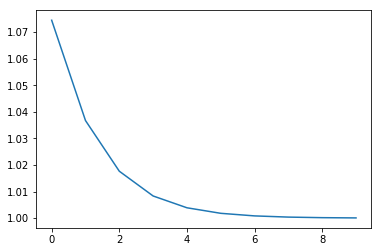

In [23]:
plt.plot(history.history['loss'])

# SIEMASE + Cross entropy

In [16]:
def my_log_softmax(x):
    return K.log(K.softmax(x))

In [17]:
left_input = Input(shape=(20,300), name = 'n')
mid_input = Input(shape=(20,300), name = 'q')
# right_input = Input(shape=(20,300), name = 'p')

conv1 = layers.Conv1D(128,5, activation='tanh',kernel_regularizer=regularizers.l2(1e-4),input_shape = (None,20,300))
max_pool1 = layers.MaxPooling1D(3)

conv2 = layers.Conv1D(256, 3, activation='tanh',kernel_regularizer=regularizers.l2(1e-4))
max_pool2 = layers.MaxPooling1D(2)
avg_pool2 = layers.AveragePooling1D(2)

flatten = layers.Flatten()

left_output = conv1(left_input)
left_output = max_pool1(left_output)

left_output = conv2(left_output)
left_output = layers.concatenate([max_pool2(left_output),avg_pool2(left_output)], axis = -1)

left_output = flatten(left_output)


mid_output = conv1(mid_input)
mid_output = max_pool1(mid_output)

mid_output = conv2(mid_output)
mid_output = layers.concatenate([max_pool2(mid_output),avg_pool2(mid_output)], axis = -1)

mid_output = flatten(mid_output)



merged_L = layers.concatenate([left_output, mid_output], axis=-1)
# merged_R = layers.concatenate([right_output, mid_output], axis=-1)


dens1 = layers.Dense(256,activation='tanh',kernel_regularizer=regularizers.l2(1e-4))

droprout1 = layers.Dropout(0.5)

merged_L = droprout1(dens1(merged_L))
# merged_R = droprout1(dens1(merged_R))



dens2 = layers.Dense(256, activation='tanh',kernel_regularizer=regularizers.l2(1e-4))
dens_pred = layers.Dense(1, activation=my_log_softmax,kernel_regularizer=regularizers.l2(1e-4))

# pred_L = dens_pred(dens2(merged_L))
# pred_R = dens_pred(dens2(merged_R))

dens_pred = dens_pred(dens2(merged_L))


# pred = layers.concatenate([pred_L,pred_R], axis = -1)

model = Model(inputs = [left_input, mid_input], outputs = dens_pred)

In [18]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False))

In [19]:
model.save('modelCrossEntropy.h5')

In [27]:
etyk = np.random.randint(2, size=len(question)).astype(float)
etyk[etyk > 0.0] = .99

In [28]:
model.fit({'n' : negative, 'q' : question, 'p' : positive},
          etyk,          
          epochs=10, 
          batch_size = 50,
          verbose=2)

Epoch 1/10
 - 5s - loss: 0.0143
Epoch 2/10
 - 4s - loss: 3.6975e-06
Epoch 3/10
 - 4s - loss: 8.0356e-10
Epoch 4/10
 - 4s - loss: 1.1099e-13
Epoch 5/10
 - 4s - loss: 6.8911e-19
Epoch 6/10
 - 5s - loss: 4.9822e-27
Epoch 7/10
 - 4s - loss: 1.9228e-34
Epoch 8/10
 - 4s - loss: 0.0000e+00
Epoch 9/10
 - 4s - loss: 0.0000e+00
Epoch 10/10
 - 4s - loss: 0.0000e+00


# SIEMASE + TRIPLET + LSTM 

In [18]:
left_input = Input(shape=(20,300), name = 'n')
mid_input = Input(shape=(20,300), name = 'q')
right_input = Input(shape=(20,300), name = 'p')

lstm1 = layers.LSTM(50, kernel_regularizer = regularizers.l2(1e-4), input_shape = (None,20,300))
#conv1 = layers.Conv1D(128,5, activation='tanh',kernel_regularizer=regularizers.l2(1e-4),input_shape = (None,20,300))
max_pool1 = layers.MaxPooling1D(2)

lstm2 = layers.LSTM(50, kernel_regularizer = regularizers.l2(1e-4), input_shape = (None,20,300))
#conv2 = layers.Conv1D(256, 3, activation='tanh',kernel_regularizer=regularizers.l2(1e-4))
max_pool2 = layers.MaxPooling1D(2)
avg_pool2 = layers.AveragePooling1D(2)


flatten = layers.Flatten()


left_output = lstm1(left_input)
left_output = max_pool1(left_output)

left_output = lstm2(left_output)
left_output = layers.concatenate([max_pool2(left_output),avg_pool2(left_output)], axis = -1)

left_output = flatten(left_output)


mid_output = lstm1(mid_input)
mid_output = max_pool1(mid_output)

mid_output = lstm2(mid_output)
mid_output = layers.concatenate([max_pool2(mid_output),avg_pool2(mid_output)], axis = -1)

mid_output = flatten(mid_output)


right_output = lstm1(right_input)
right_output = max_pool1(right_output)

right_output = lstm2(right_output)
right_output = layers.concatenate([max_pool2(right_output),avg_pool2(right_output)], axis = -1)

right_output = flatten(right_output)



merged_L = layers.concatenate([left_output, mid_output], axis=-1)
merged_R = layers.concatenate([right_output, mid_output], axis=-1)


dens1 = layers.Dense(256,activation='tanh',kernel_regularizer=regularizers.l2(1e-4))

droprout1 = layers.Dropout(0.05)

merged_L = droprout1(dens1(merged_L))
merged_R = droprout1(dens1(merged_R))



dens2 = layers.Dense(256, activation='tanh',kernel_regularizer=regularizers.l2(1e-4))
dens_pred = layers.Dense(1, activation='softmax',kernel_regularizer=regularizers.l2(1e-4))

pred_L = dens_pred(dens2(merged_L))
pred_R = dens_pred(dens2(merged_R))




pred = layers.concatenate([pred_L,pred_R], axis = -1)

model = Model(inputs = [left_input, mid_input, right_input], outputs = pred)


In [20]:
history = model.fit({'n' : negative, 'q' : question, 'p' : positive},
          np.zeros(len(question)),   
          epochs=10, 
          batch_size = 50,
          verbose=1)

Epoch 1/10
8484/8484 [==============================] - 4s 524us/step - loss: 1.0000
Epoch 2/10
8484/8484 [==============================] - 5s 546us/step - loss: 1.0000
Epoch 3/10
8484/8484 [==============================] - 5s 562us/step - loss: 1.0000
Epoch 4/10
8484/8484 [==============================] - 5s 543us/step - loss: 1.0000
Epoch 5/10
8484/8484 [==============================] - 5s 547us/step - loss: 1.0000
Epoch 6/10
8484/8484 [==============================] - 5s 564us/step - loss: 1.0000
Epoch 7/10
8484/8484 [==============================] - 5s 582us/step - loss: 1.0000
Epoch 8/10
8484/8484 [==============================] - 4s 528us/step - loss: 1.0000
Epoch 9/10
8484/8484 [==============================] - 5s 619us/step - loss: 1.0000
Epoch 10/10
8484/8484 [==============================] - 5s 593us/step - loss: 1.0000


# Siamese + Trilpet exacly as in Paper

In [21]:
left_input = Input(shape=(20,300), name = 'n')
mid_input = Input(shape=(20,300), name = 'q')
right_input = Input(shape=(20,300), name = 'p')

In [22]:
flatten = layers.Flatten()

In [23]:
#Window size  = 3
conv1_min_window_size_3 = layers.Conv1D(300,3, activation='tanh',
                                        kernel_regularizer=regularizers.l2(1e-4),input_shape = (None,20,300))
min_pool_1_size_3 = layers.GlobalMaxPooling1D()

conv1_max_window_size_3 = layers.Conv1D(300,3, activation='tanh',
                                        kernel_regularizer=regularizers.l2(1e-4),input_shape = (None,20,300))
max_pool_1_size_3 = layers.GlobalMaxPooling1D()

conv1_avg_window_size_3 = layers.Conv1D(300,3, activation='tanh',
                                        kernel_regularizer=regularizers.l2(1e-4),input_shape = (None,20,300))
avg_pool_1_size_3 = layers.GlobalAveragePooling1D()

In [24]:
#Window size  = 2
conv1_min_window_size_2 = layers.Conv1D(300,2, activation='tanh',
                                        kernel_regularizer=regularizers.l2(1e-4),input_shape = (None,20,300))
min_pool_1_size_2 = layers.GlobalMaxPooling1D()

conv1_max_window_size_2 = layers.Conv1D(300,2, activation='tanh',
                                        kernel_regularizer=regularizers.l2(1e-4),input_shape = (None,20,300))
max_pool_1_size_2 = layers.GlobalMaxPooling1D()

conv1_avg_window_size_2 = layers.Conv1D(300,2, activation='tanh',
                                        kernel_regularizer=regularizers.l2(1e-4),input_shape = (None,20,300))
avg_pool_1_size_2 = layers.GlobalAveragePooling1D()

In [25]:
#Window size  = Infty = 20
min_pool_1_size_20 = layers.GlobalMaxPooling1D()

max_pool_1_size_20 = layers.GlobalMaxPooling1D()

avg_pool_1_size_20 = layers.GlobalAveragePooling1D()

In [26]:
# As there is no MinPooling in Keras, I use MaxPooling from - 1 * vector

left_size3_max = max_pool_1_size_3(conv1_max_window_size_3(left_input))
left_size3_min = min_pool_1_size_3(layers.Lambda(lambda x : x * -1 )(conv1_min_window_size_3(left_input)))
left_size3_avg = avg_pool_1_size_3(conv1_avg_window_size_3(left_input))

mid_size3_max = max_pool_1_size_3(conv1_max_window_size_3(mid_input))
mid_size3_min = min_pool_1_size_3(layers.Lambda(lambda x : x * -1 )(conv1_min_window_size_3(mid_input)))
mid_size3_avg = avg_pool_1_size_3(conv1_avg_window_size_3(mid_input))

right_size3_max = max_pool_1_size_3(conv1_max_window_size_3(right_input))
right_size3_min = min_pool_1_size_3(layers.Lambda(lambda x : x * -1 )(conv1_min_window_size_3(right_input)))
right_size3_avg = avg_pool_1_size_3(conv1_avg_window_size_3(right_input))



left_size2_max  = max_pool_1_size_2(conv1_max_window_size_2(left_input))
left_size2_min = min_pool_1_size_2(layers.Lambda(lambda x : x * -1 )(conv1_min_window_size_2(left_input)))
left_size2_avg = avg_pool_1_size_2(conv1_avg_window_size_2(left_input))

mid_size2_max = max_pool_1_size_2(conv1_max_window_size_2(mid_input))
mid_size2_min = min_pool_1_size_2(layers.Lambda(lambda x : x * -1 )(conv1_min_window_size_2(mid_input)))
mid_size2_avg = avg_pool_1_size_2(conv1_avg_window_size_2(mid_input))

right_size2_max = max_pool_1_size_2(conv1_max_window_size_3(right_input))
right_size2_min = min_pool_1_size_2(layers.Lambda(lambda x : x * -1 )(conv1_min_window_size_3(right_input)))
right_size2_avg = avg_pool_1_size_2(conv1_avg_window_size_3(right_input))



left_sizeInf_max  = max_pool_1_size_20(left_input)
left_sizeInf_min = min_pool_1_size_20(layers.Lambda(lambda x : x * -1 )(left_input))
left_sizeInf_avg = avg_pool_1_size_20(left_input)

mid_sizeInf_max = max_pool_1_size_20(mid_input)
mid_sizeInf_min = min_pool_1_size_20(layers.Lambda(lambda x : x * -1 )(mid_input))
mid_sizeInf_avg = avg_pool_1_size_20(mid_input)

right_sizeInf_max = max_pool_1_size_20(right_input)
right_sizeInf_min = min_pool_1_size_20(layers.Lambda(lambda x : x * -1 )(right_input))
right_sizeInf_avg = avg_pool_1_size_20(right_input)

In [27]:
# Per-dimension filters
   
per_dimension_layers_size_2_max = \
[[layers.Conv1D(3,2, activation='tanh',kernel_regularizer=regularizers.l2(1e-4),input_shape = (None,20,1))]
for i in range(300)]


per_dimension_layers_size_3_max = \
[[layers.Conv1D(3,3, activation='tanh',kernel_regularizer=regularizers.l2(1e-4),input_shape = (None,20,1))]
for i in range(300)]


per_dimension_layers_size_2_min = \
[[layers.Conv1D(3,2, activation='tanh',kernel_regularizer=regularizers.l2(1e-4),input_shape = (None,20,1))]
for i in range(300)]


per_dimension_layers_size_3_min = \
[[layers.Conv1D(3,3, activation='tanh',kernel_regularizer=regularizers.l2(1e-4),input_shape = (None,20,1))]
for i in range(300)]
 

In [28]:
# Per dimension filters cd

 
left_single_dimension_max_size2 = [layers.GlobalMaxPooling1D()(
    (per_dimension_layers_size_2_max[i][0](        
    layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],3,1]) )(layers.Lambda(lambda x : x[:,:,i])(left_input))
    ))) for i in range(300)]
left_single_dimension_min_size2 = [layers.GlobalMaxPooling1D()(
    (per_dimension_layers_size_2_min[i][0](layers.Lambda(lambda x : x * -1 )(        
    layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],3,1]) )(layers.Lambda(lambda x : x[:,:,i])(left_input))
    )))) for i in range(300)]

left_single_dimension_max_size3 = [layers.GlobalMaxPooling1D()(
    (per_dimension_layers_size_3_max[i][0](        
    layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],3,1]) )(layers.Lambda(lambda x : x[:,:,i])(left_input))
    ))) for i in range(300)]
left_single_dimension_min_size3 = [layers.GlobalMaxPooling1D()(
    (per_dimension_layers_size_3_min[i][0](layers.Lambda(lambda x : x * -1 )(        
    layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],3,1]) )(layers.Lambda(lambda x : x[:,:,i])(left_input))
    )))) for i in range(300)]


right_single_dimension_max_size2 = [layers.GlobalMaxPooling1D()(
    (per_dimension_layers_size_2_max[i][0](        
    layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],3,1]) )(layers.Lambda(lambda x : x[:,:,i])(right_input))
    ))) for i in range(300)]
right_single_dimension_min_size2 = [layers.GlobalMaxPooling1D()(
    (per_dimension_layers_size_2_min[i][0](layers.Lambda(lambda x : x * -1 )(        
    layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],3,1]) )(layers.Lambda(lambda x : x[:,:,i])(right_input))
    )))) for i in range(300)]

right_single_dimension_max_size3 = [layers.GlobalMaxPooling1D()(
    (per_dimension_layers_size_3_max[i][0](        
    layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],3,1]) )(layers.Lambda(lambda x : x[:,:,i])(right_input))
    ))) for i in range(300)]
right_single_dimension_min_size3 = [layers.GlobalMaxPooling1D()(
    (per_dimension_layers_size_3_min[i][0](layers.Lambda(lambda x : x * -1 )(        
    layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],3,1]) )(layers.Lambda(lambda x : x[:,:,i])(right_input))
    )))) for i in range(300)]


mid_single_dimension_max_size2 = [layers.GlobalMaxPooling1D()(
    (per_dimension_layers_size_2_max[i][0](        
    layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],3,1]) )(layers.Lambda(lambda x : x[:,:,i])(mid_input))
    ))) for i in range(300)]
mid_single_dimension_min_size2 = [layers.GlobalMaxPooling1D()(
    (per_dimension_layers_size_2_min[i][0](layers.Lambda(lambda x : x * -1 )(        
    layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],3,1]) )(layers.Lambda(lambda x : x[:,:,i])(mid_input))
    )))) for i in range(300)]

mid_single_dimension_max_size3 = [layers.GlobalMaxPooling1D()(
    (per_dimension_layers_size_3_max[i][0](        
    layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],3,1]) )(layers.Lambda(lambda x : x[:,:,i])(mid_input))
    ))) for i in range(300)]
mid_single_dimension_min_size3 = [layers.GlobalMaxPooling1D()(
    (per_dimension_layers_size_3_min[i][0](layers.Lambda(lambda x : x * -1 )(        
    layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],3,1]) )(layers.Lambda(lambda x : x[:,:,i])(mid_input))
    )))) for i in range(300)]

KeyboardInterrupt: 

In [ ]:
# Horizontal comparison, AKA Algorithm 1 - cosine distance + L2 distance


results_L = []
for gather in ['avg','max','min']:
  
    results_L1 = [layers.dot([
        layers.concatenate( [
        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('left_size2_%s'%(gather)))),

        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('left_size3_%s'%(gather)))),

        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('left_sizeInf_%s'%(gather))))      
      ]),
        layers.concatenate( [
        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('mid_size2_%s'%(gather)))),

        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('mid_size3_%s'%(gather)))),

        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('mid_sizeInf_%s'%(gather))))      
      ])
    ],axes = -1,normalize=True) for i in range(300)]


    results_L2 = [layers.Lambda(lambda x : tf.norm(x,ord = 2,axis=-1,keepdims=True))
        (layers.subtract([
        layers.concatenate( [
        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('left_size2_%s'%(gather)))),

        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('left_size3_%s'%(gather)))),

        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('left_sizeInf_%s'%(gather))))      
        ]),
        layers.concatenate( [
        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('mid_size2_%s'%(gather)))),

        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('mid_size3_%s'%(gather)))),

        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('mid_sizeInf_%s'%(gather))))      
      ])
    ])) for i in range(300)]


    results_L += results_L1
    results_L += results_L2

horizontal_left_compared = layers.concatenate(results_L)

del results_L
del results_L1
del results_L2

In [ ]:
# Horizontal comparison, AKA Algorithm 1 - cosine distance + L2 distance


results_R = []
for gather in ['avg','max','min']:
  
    results_R1 = [layers.dot([
        layers.concatenate( [
        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('right_size2_%s'%(gather)))),

        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('right_size3_%s'%(gather)))),

        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('right_sizeInf_%s'%(gather))))      
      ]),
        layers.concatenate( [
        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('mid_size2_%s'%(gather)))),

        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('mid_size3_%s'%(gather)))),

        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('mid_sizeInf_%s'%(gather))))      
      ])
    ],axes = -1,normalize=True) for i in range(300)]


    results_R2 = [layers.Lambda(lambda x : tf.norm(x,ord = 2,axis=-1,keepdims=True))
        (layers.subtract([
        layers.concatenate( [
        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('right_size2_%s'%(gather)))),

        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('right_size3_%s'%(gather)))),

        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('right_sizeInf_%s'%(gather))))      
        ]),
        layers.concatenate( [
        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('mid_size2_%s'%(gather)))),

        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('mid_size3_%s'%(gather)))),

        layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1]) )
        (layers.Lambda(lambda x : x[:,i])(eval('mid_sizeInf_%s'%(gather))))      
      ])
    ])) for i in range(300)]


    results_R += results_R1
    results_R += results_R2
    
horizontal_right_compared = layers.concatenate(results_R)

del results_R
del results_R1
del results_R2

In [ ]:
#Vertical comparison,AKA Algorithm 2 - cosine distance + L2 distance + L1 distance

v_results_L = []
for gather in ['avg','max','min']:
    for num,s1 in enumerate(['2','3','Inf']): 
        for s2 in ['2','3','Inf'][num:]:
        
            
            v_results_L.append(layers.dot([
                    eval('left_size%s_%s'%(s1,gather)),eval('mid_size%s_%s'%(s2,gather))
                ],axes = -1,normalize=True))
            v_results_L.append(layers.Lambda(lambda x : tf.norm(x,ord = 2,axis=-1,keepdims=True))
                         (layers.subtract([
                    eval('left_size%s_%s'%(s1,gather)),eval('mid_size%s_%s'%(s2,gather))])))
            v_results_L.append(layers.Lambda(lambda x : tf.norm(x,ord = 1,axis=-1,keepdims=True))
                         (layers.subtract([
                    eval('left_size%s_%s'%(s1,gather)),eval('mid_size%s_%s'%(s2,gather))])))    

    if gather != 'avg':
        for s1 in ['2','3']:    
            
            v_results_L1 = [layers.dot([
                layers.concatenate([(layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1])))
                                (layers.Lambda(lambda x : x[:,i])(lay))
                   for lay in eval('left_single_dimension_%s_size%s'%(gather,s1))]),
                layers.concatenate([(layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1])))
                                (layers.Lambda(lambda x : x[:,i])(lay))
                   for lay in eval('mid_single_dimension_%s_size%s'%(gather,s1))])
            ],axes = -1,normalize=True) for i in range(3)]

            v_results_L2 = [layers.Lambda(lambda x : tf.norm(x,ord = 2,axis=-1,keepdims=True))
                (layers.subtract([
                layers.concatenate([(layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1])))
                                (layers.Lambda(lambda x : x[:,i])(lay))
                   for lay in eval('left_single_dimension_%s_size%s'%(gather,s1))]),
                layers.concatenate([(layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1])))
                                (layers.Lambda(lambda x : x[:,i])(lay))
                   for lay in eval('mid_single_dimension_%s_size%s'%(gather,s1))])
            ])) for i in range(3)]

            v_results_L3 = [layers.Lambda(lambda x : tf.norm(x,ord = 1,axis=-1,keepdims=True))
                (layers.subtract([
                layers.concatenate([(layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1])))
                                (layers.Lambda(lambda x : x[:,i])(lay))
                   for lay in eval('left_single_dimension_%s_size%s'%(gather,s1))]),
                layers.concatenate([(layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1])))
                                (layers.Lambda(lambda x : x[:,i])(lay))
                   for lay in eval('mid_single_dimension_%s_size%s'%(gather,s1))])
            ])) for i in range(3)]
            
            v_results_L += v_results_L1
            v_results_L += v_results_L2
            v_results_L += v_results_L3
            
vertical_left_compared = layers.concatenate(v_results_L)

del v_results_L
del v_results_L1
del v_results_L2
del v_results_L3

In [ ]:
#Vertical comparison,AKA Algorithm 2 - cosine distance + L2 distance + L1 distance

v_results_R = []
for gather in ['avg','max','min']:
    for num,s1 in enumerate(['2','3','Inf']): 
        for s2 in ['2','3','Inf'][num:]:
        
            
            v_results_R.append(layers.dot([
                    eval('right_size%s_%s'%(s1,gather)),eval('mid_size%s_%s'%(s2,gather))
                ],axes = -1,normalize=True))
            v_results_R.append(layers.Lambda(lambda x : tf.norm(x,ord = 2,axis=-1,keepdims=True))
                         (layers.subtract([
                    eval('right_size%s_%s'%(s1,gather)),eval('mid_size%s_%s'%(s2,gather))])))
            v_results_R.append(layers.Lambda(lambda x : tf.norm(x,ord = 1,axis=-1,keepdims=True))
                         (layers.subtract([
                    eval('right_size%s_%s'%(s1,gather)),eval('mid_size%s_%s'%(s2,gather))])))    

    if gather != 'avg':
        for s1 in ['2','3']:    
            
            v_results_R1 = [layers.dot([
                layers.concatenate([(layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1])))
                                (layers.Lambda(lambda x : x[:,i])(lay))
                   for lay in eval('right_single_dimension_%s_size%s'%(gather,s1))]),
                layers.concatenate([(layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1])))
                                (layers.Lambda(lambda x : x[:,i])(lay))
                   for lay in eval('mid_single_dimension_%s_size%s'%(gather,s1))])
            ],axes = -1,normalize=True) for i in range(3)]

            v_results_R2 = [layers.Lambda(lambda x : tf.norm(x,ord = 2,axis=-1,keepdims=True))
                (layers.subtract([
                layers.concatenate([(layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1])))
                                (layers.Lambda(lambda x : x[:,i])(lay))
                   for lay in eval('right_single_dimension_%s_size%s'%(gather,s1))]),
                layers.concatenate([(layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1])))
                                (layers.Lambda(lambda x : x[:,i])(lay))
                   for lay in eval('mid_single_dimension_%s_size%s'%(gather,s1))])
            ])) for i in range(3)]

            v_results_R3 = [layers.Lambda(lambda x : tf.norm(x,ord = 1,axis=-1,keepdims=True))
                (layers.subtract([
                layers.concatenate([(layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1])))
                                (layers.Lambda(lambda x : x[:,i])(lay))
                   for lay in eval('right_single_dimension_%s_size%s'%(gather,s1))]),
                layers.concatenate([(layers.Lambda(lambda x : K.reshape(x,[K.shape(x)[0],1])))
                                (layers.Lambda(lambda x : x[:,i])(lay))
                   for lay in eval('mid_single_dimension_%s_size%s'%(gather,s1))])
            ])) for i in range(3)]
            
            v_results_R += v_results_R1
            v_results_R += v_results_R2
            v_results_R += v_results_R3
            
vertical_right_compared = layers.concatenate(v_results_R)

del v_results_R
del v_results_R1
del v_results_R2
del v_results_R3

In [ ]:
# Add dense layers at the top of network

dens1 = layers.Dense(256,activation='tanh',kernel_regularizer=regularizers.l2(1e-4))

droprout1 = layers.Dropout(0.5)


merged_L = droprout1(dens1(layers.concatenate([horizontal_left_compared,vertical_left_compared])))
merged_R = droprout1(dens1(layers.concatenate([horizontal_right_compared,vertical_left_compared])))


dens2 = layers.Dense(256, activation='tanh',kernel_regularizer=regularizers.l2(1e-4))
dens_pred = layers.Dense(1, activation=my_log_softmax,kernel_regularizer=regularizers.l2(1e-4))

pred_L = dens_pred(dens2(merged_L))
pred_R = dens_pred(dens2(merged_R))




pred = layers.concatenate([pred_L,pred_R], axis = -1)

model = Model(inputs = [left_input, mid_input, right_input], outputs = pred)

In [ ]:
model.summary()

In [ ]:
model.compile(loss=triplet_loss, 
              optimizer=optimizers.Adam(lr=0.001,clipnorm=1.))

In [ ]:
model.fit({'n' : negative, 'q' : question, 'p' : positive},
          np.zeros(len(negative)), #anything, basicly, not importent for loss function
          epochs=10, 
          batch_size = 128,
          verbose=1)